# Generating Faces with Generative Adversarial Networks (GAN's)

## Nick Koutroumpinis, ML|mind Software Development
In this project, we'll use generative adversarial networks to generate new images of faces.
### Get the Data
We'll be using two datasets in this project:
- MNIST
- CelebA


In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:14<00:00, 4.15KFile/s] 


Extracting celeba...


## Explore the Data
### MNIST
As we're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. We can view the first number of examples by changing `show_n_images`. 

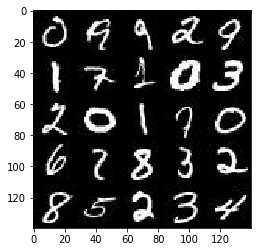

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since we're going to be generating faces, we won't need the annotations. We can view the first number of examples by changing `show_n_images`.

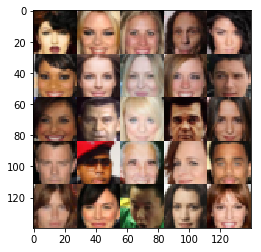

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
We'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure we have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
We are going to implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.


In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels],
                                name='input_real')
    
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    
    learning_rate = tf.placeholder(tf.float32, shape=[], name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
We are going to implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network. We use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        #14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        # 4x4x256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
We are going to implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        # 7x7x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # 14x14x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # 28x28x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
We are going to implement `model_loss` to build the GANs for training and calculate the loss. The function should return a tuple of (discriminator loss, generator loss). We'll use the following functions we implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen = generator(input_z, out_channel_dim)
    disc_model_real, disc_logits_real = discriminator(input_real)
    disc_model_fake, disc_logits_fake = discriminator(gen, reuse=True)
    
    smoothen = (1 - 0.1)
    labels_smooth = tf.ones_like(disc_model_real) * smoothen
    
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real,
                                                                         labels=labels_smooth))
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                         labels=tf.zeros_like(disc_model_fake)))
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake,
                                                                    labels=tf.ones_like(disc_model_fake)))
    
    disc_loss = disc_loss_real + disc_loss_fake
    
    return disc_loss, gen_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
We are going to implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables. We will also filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
   
    
    variables = tf.trainable_variables()
    disc_vars = []
    gen_vars = []
    
    for var in variables:
        if var.name.startswith('discriminator'):
            disc_vars.append(var)
        else:
            gen_vars.append(var)

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
We are using this function to show the current output of the generator during training. It will help us determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
We are going to implement `train` to build and train the GANs. We will use the following functions we implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

We'll also use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode,
          print_every=10, show_every=100):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr_placeholder = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images *= 2.0
                
                # put some noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run the sessions
                s1 = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                s2 = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                steps += 1
                    
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test our GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.

Epoch 1/2... Discriminator Loss: 0.5345... Generator Loss: 1.9096
Epoch 1/2... Discriminator Loss: 0.4322... Generator Loss: 2.6088
Epoch 1/2... Discriminator Loss: 0.4014... Generator Loss: 3.0183
Epoch 1/2... Discriminator Loss: 0.3694... Generator Loss: 3.6751
Epoch 1/2... Discriminator Loss: 0.3925... Generator Loss: 3.5569
Epoch 1/2... Discriminator Loss: 0.6675... Generator Loss: 2.3054
Epoch 1/2... Discriminator Loss: 0.3564... Generator Loss: 4.7401
Epoch 1/2... Discriminator Loss: 0.3719... Generator Loss: 3.7421
Epoch 1/2... Discriminator Loss: 0.3607... Generator Loss: 3.8678
Epoch 1/2... Discriminator Loss: 0.3729... Generator Loss: 3.7430


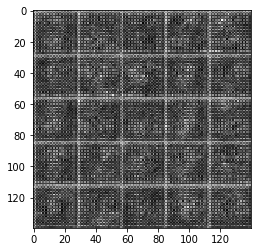

Epoch 1/2... Discriminator Loss: 0.3640... Generator Loss: 3.6714
Epoch 1/2... Discriminator Loss: 0.3675... Generator Loss: 3.9012
Epoch 1/2... Discriminator Loss: 0.3428... Generator Loss: 4.4105
Epoch 1/2... Discriminator Loss: 0.4446... Generator Loss: 3.0561
Epoch 1/2... Discriminator Loss: 0.5023... Generator Loss: 2.4891
Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 4.5261
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 4.5264
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 4.6441
Epoch 1/2... Discriminator Loss: 0.3889... Generator Loss: 4.1795
Epoch 1/2... Discriminator Loss: 0.3475... Generator Loss: 4.4777


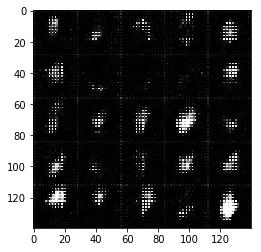

Epoch 1/2... Discriminator Loss: 0.4373... Generator Loss: 3.0328
Epoch 1/2... Discriminator Loss: 0.3748... Generator Loss: 3.6650
Epoch 1/2... Discriminator Loss: 0.4908... Generator Loss: 2.3443
Epoch 1/2... Discriminator Loss: 0.4385... Generator Loss: 3.7235
Epoch 1/2... Discriminator Loss: 0.5414... Generator Loss: 3.4727
Epoch 1/2... Discriminator Loss: 1.2273... Generator Loss: 0.7158
Epoch 1/2... Discriminator Loss: 0.5047... Generator Loss: 2.6852
Epoch 1/2... Discriminator Loss: 0.5473... Generator Loss: 2.6615
Epoch 1/2... Discriminator Loss: 1.3329... Generator Loss: 0.6963
Epoch 1/2... Discriminator Loss: 0.7654... Generator Loss: 2.0298


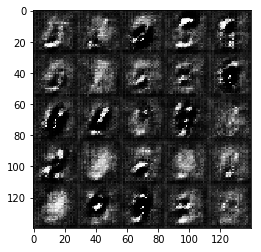

Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 1.1486
Epoch 1/2... Discriminator Loss: 0.8846... Generator Loss: 3.0248
Epoch 1/2... Discriminator Loss: 1.2295... Generator Loss: 0.7458
Epoch 1/2... Discriminator Loss: 1.1847... Generator Loss: 0.6880
Epoch 1/2... Discriminator Loss: 0.6469... Generator Loss: 2.8546
Epoch 1/2... Discriminator Loss: 0.7344... Generator Loss: 1.4768
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 3.1769
Epoch 1/2... Discriminator Loss: 0.8315... Generator Loss: 2.0301
Epoch 1/2... Discriminator Loss: 0.8830... Generator Loss: 2.3897
Epoch 1/2... Discriminator Loss: 0.8136... Generator Loss: 1.7384


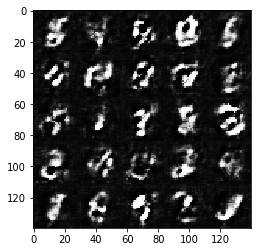

Epoch 1/2... Discriminator Loss: 0.8334... Generator Loss: 1.0732
Epoch 1/2... Discriminator Loss: 0.6300... Generator Loss: 2.1337
Epoch 1/2... Discriminator Loss: 0.7476... Generator Loss: 1.9642
Epoch 1/2... Discriminator Loss: 0.7423... Generator Loss: 2.0549
Epoch 1/2... Discriminator Loss: 0.6670... Generator Loss: 1.6715
Epoch 1/2... Discriminator Loss: 0.7270... Generator Loss: 1.3726
Epoch 1/2... Discriminator Loss: 0.6361... Generator Loss: 1.8675
Epoch 1/2... Discriminator Loss: 0.6203... Generator Loss: 1.8495
Epoch 1/2... Discriminator Loss: 0.6187... Generator Loss: 1.7312
Epoch 1/2... Discriminator Loss: 0.6456... Generator Loss: 1.7007


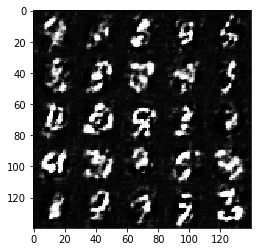

Epoch 1/2... Discriminator Loss: 0.6673... Generator Loss: 2.5327
Epoch 1/2... Discriminator Loss: 0.6381... Generator Loss: 2.3103
Epoch 1/2... Discriminator Loss: 1.3211... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 0.6104... Generator Loss: 2.4136
Epoch 1/2... Discriminator Loss: 0.6216... Generator Loss: 1.7093
Epoch 1/2... Discriminator Loss: 0.6577... Generator Loss: 1.8010
Epoch 1/2... Discriminator Loss: 0.5204... Generator Loss: 2.2720
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 1.7344
Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 0.8020
Epoch 1/2... Discriminator Loss: 0.6460... Generator Loss: 1.9718


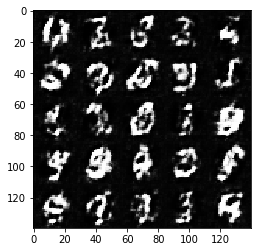

Epoch 1/2... Discriminator Loss: 0.6302... Generator Loss: 2.5972
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.1324
Epoch 1/2... Discriminator Loss: 0.5380... Generator Loss: 2.5138
Epoch 1/2... Discriminator Loss: 0.6241... Generator Loss: 1.9359
Epoch 1/2... Discriminator Loss: 0.6198... Generator Loss: 1.9774
Epoch 1/2... Discriminator Loss: 0.5945... Generator Loss: 2.4403
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.3615
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 0.6959... Generator Loss: 1.4109
Epoch 1/2... Discriminator Loss: 0.5674... Generator Loss: 2.1062


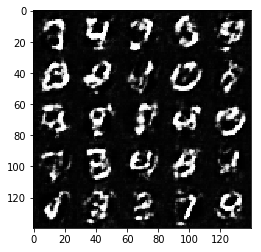

Epoch 1/2... Discriminator Loss: 0.5837... Generator Loss: 1.8991
Epoch 1/2... Discriminator Loss: 0.5642... Generator Loss: 1.8894
Epoch 1/2... Discriminator Loss: 0.6319... Generator Loss: 1.8481
Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 1.0021
Epoch 1/2... Discriminator Loss: 0.6470... Generator Loss: 2.0228
Epoch 1/2... Discriminator Loss: 0.8611... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 0.5793... Generator Loss: 2.3936
Epoch 1/2... Discriminator Loss: 0.6766... Generator Loss: 1.3892
Epoch 1/2... Discriminator Loss: 0.6532... Generator Loss: 2.8039
Epoch 1/2... Discriminator Loss: 0.6079... Generator Loss: 1.7724


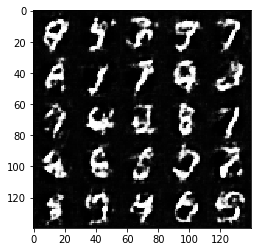

Epoch 1/2... Discriminator Loss: 0.5476... Generator Loss: 2.1653
Epoch 1/2... Discriminator Loss: 0.5690... Generator Loss: 2.6430
Epoch 1/2... Discriminator Loss: 0.5676... Generator Loss: 2.0222
Epoch 1/2... Discriminator Loss: 2.7958... Generator Loss: 0.1548
Epoch 1/2... Discriminator Loss: 0.6779... Generator Loss: 1.6292
Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 1.8223
Epoch 1/2... Discriminator Loss: 0.6621... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 0.5914... Generator Loss: 1.9149
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.8247
Epoch 1/2... Discriminator Loss: 0.6327... Generator Loss: 1.5890


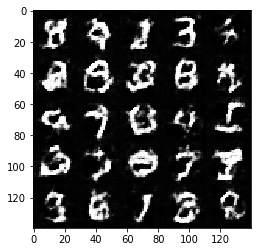

Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.2985
Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 2.0826
Epoch 1/2... Discriminator Loss: 0.6649... Generator Loss: 2.4470
Epoch 2/2... Discriminator Loss: 0.5936... Generator Loss: 1.6886
Epoch 2/2... Discriminator Loss: 0.6521... Generator Loss: 2.0076
Epoch 2/2... Discriminator Loss: 0.5503... Generator Loss: 1.9233
Epoch 2/2... Discriminator Loss: 0.6550... Generator Loss: 1.5275
Epoch 2/2... Discriminator Loss: 0.9333... Generator Loss: 2.4753
Epoch 2/2... Discriminator Loss: 0.7751... Generator Loss: 1.2562
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.0548


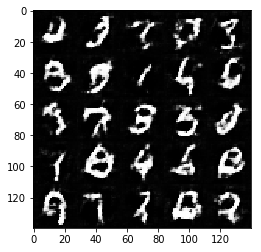

Epoch 2/2... Discriminator Loss: 0.5934... Generator Loss: 1.7720
Epoch 2/2... Discriminator Loss: 0.5938... Generator Loss: 1.7399
Epoch 2/2... Discriminator Loss: 0.7577... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 0.7265... Generator Loss: 1.3507
Epoch 2/2... Discriminator Loss: 0.5822... Generator Loss: 1.7078
Epoch 2/2... Discriminator Loss: 0.6795... Generator Loss: 2.0726
Epoch 2/2... Discriminator Loss: 0.8721... Generator Loss: 1.0450
Epoch 2/2... Discriminator Loss: 0.6420... Generator Loss: 1.6154
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.9340
Epoch 2/2... Discriminator Loss: 0.6784... Generator Loss: 2.1160


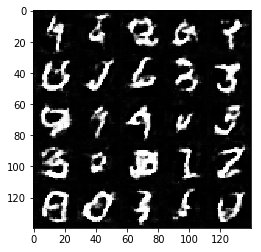

Epoch 2/2... Discriminator Loss: 0.6320... Generator Loss: 1.7553
Epoch 2/2... Discriminator Loss: 0.6693... Generator Loss: 1.6370
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.9570
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.0242
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 0.9228
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.1794
Epoch 2/2... Discriminator Loss: 1.0397... Generator Loss: 3.4717
Epoch 2/2... Discriminator Loss: 2.4432... Generator Loss: 0.2089
Epoch 2/2... Discriminator Loss: 0.6602... Generator Loss: 1.7282
Epoch 2/2... Discriminator Loss: 0.8796... Generator Loss: 1.0078


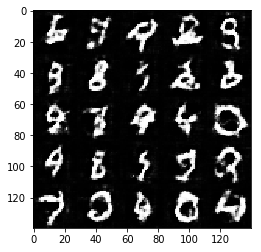

Epoch 2/2... Discriminator Loss: 0.7406... Generator Loss: 1.2898
Epoch 2/2... Discriminator Loss: 0.7419... Generator Loss: 1.2966
Epoch 2/2... Discriminator Loss: 0.7735... Generator Loss: 1.2279
Epoch 2/2... Discriminator Loss: 0.7168... Generator Loss: 1.3207
Epoch 2/2... Discriminator Loss: 1.0218... Generator Loss: 0.8115
Epoch 2/2... Discriminator Loss: 0.6656... Generator Loss: 1.4890
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 0.7928... Generator Loss: 1.1870
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.8403
Epoch 2/2... Discriminator Loss: 0.6592... Generator Loss: 1.5048


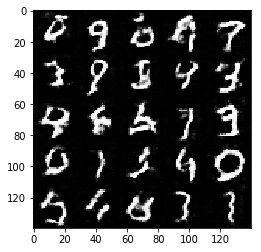

Epoch 2/2... Discriminator Loss: 1.0908... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 0.9776... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 0.7957... Generator Loss: 1.3382
Epoch 2/2... Discriminator Loss: 0.6925... Generator Loss: 1.4011
Epoch 2/2... Discriminator Loss: 0.5958... Generator Loss: 1.7344
Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 1.7327
Epoch 2/2... Discriminator Loss: 0.7781... Generator Loss: 1.3878
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.4210
Epoch 2/2... Discriminator Loss: 0.8815... Generator Loss: 1.0382
Epoch 2/2... Discriminator Loss: 0.6724... Generator Loss: 1.7948


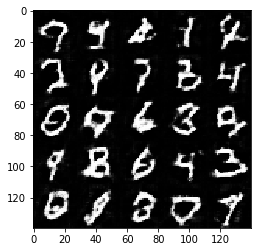

Epoch 2/2... Discriminator Loss: 0.7572... Generator Loss: 2.3179
Epoch 2/2... Discriminator Loss: 0.7903... Generator Loss: 1.1902
Epoch 2/2... Discriminator Loss: 0.7383... Generator Loss: 1.3553
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.5018
Epoch 2/2... Discriminator Loss: 0.8383... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 0.6889... Generator Loss: 1.4447
Epoch 2/2... Discriminator Loss: 1.0710... Generator Loss: 0.7405
Epoch 2/2... Discriminator Loss: 0.6697... Generator Loss: 1.8549
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 1.8383
Epoch 2/2... Discriminator Loss: 0.5606... Generator Loss: 2.4492


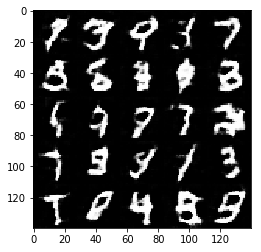

Epoch 2/2... Discriminator Loss: 0.8053... Generator Loss: 1.5359
Epoch 2/2... Discriminator Loss: 0.7076... Generator Loss: 1.5372
Epoch 2/2... Discriminator Loss: 0.6274... Generator Loss: 1.6240
Epoch 2/2... Discriminator Loss: 0.6990... Generator Loss: 1.4326
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.8114
Epoch 2/2... Discriminator Loss: 0.7799... Generator Loss: 1.1995
Epoch 2/2... Discriminator Loss: 0.6980... Generator Loss: 1.4977
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.1025
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.4266
Epoch 2/2... Discriminator Loss: 0.7823... Generator Loss: 1.2234


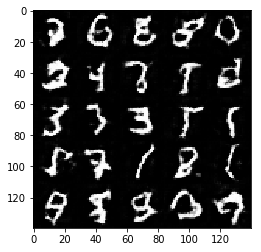

Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 1.1991
Epoch 2/2... Discriminator Loss: 0.6932... Generator Loss: 1.4191
Epoch 2/2... Discriminator Loss: 0.7381... Generator Loss: 1.3601
Epoch 2/2... Discriminator Loss: 0.6245... Generator Loss: 1.6864
Epoch 2/2... Discriminator Loss: 0.7643... Generator Loss: 1.5372
Epoch 2/2... Discriminator Loss: 0.7338... Generator Loss: 1.5634
Epoch 2/2... Discriminator Loss: 0.5926... Generator Loss: 1.8822
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.4667
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.3813
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.3070


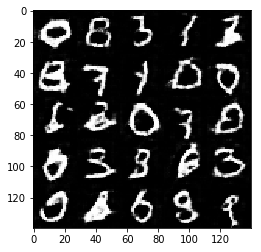

Epoch 2/2... Discriminator Loss: 0.7176... Generator Loss: 1.4058
Epoch 2/2... Discriminator Loss: 0.8764... Generator Loss: 0.9997
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.9127
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 2.3007
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 0.8304
Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 2.3368
Epoch 2/2... Discriminator Loss: 0.7801... Generator Loss: 1.3604
Epoch 2/2... Discriminator Loss: 0.6727... Generator Loss: 1.4985
Epoch 2/2... Discriminator Loss: 0.8373... Generator Loss: 1.0655
Epoch 2/2... Discriminator Loss: 0.6894... Generator Loss: 1.5565


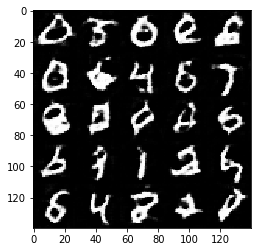

Epoch 2/2... Discriminator Loss: 0.8671... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 0.8398... Generator Loss: 1.0649
Epoch 2/2... Discriminator Loss: 0.9380... Generator Loss: 0.9381
Epoch 2/2... Discriminator Loss: 1.8642... Generator Loss: 0.3943
Epoch 2/2... Discriminator Loss: 0.7865... Generator Loss: 1.4791
Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.6362
Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.8586


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run our GANs on CelebA. It will take around 20 minutes on the average GPU to run one epoch.

Epoch 1/1... Discriminator Loss: 0.7968... Generator Loss: 1.2687
Epoch 1/1... Discriminator Loss: 0.5658... Generator Loss: 1.8879
Epoch 1/1... Discriminator Loss: 0.4971... Generator Loss: 2.1839
Epoch 1/1... Discriminator Loss: 0.4393... Generator Loss: 2.6563
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 2.9538
Epoch 1/1... Discriminator Loss: 0.3934... Generator Loss: 3.3327
Epoch 1/1... Discriminator Loss: 0.3743... Generator Loss: 3.3731
Epoch 1/1... Discriminator Loss: 0.4015... Generator Loss: 2.9818
Epoch 1/1... Discriminator Loss: 0.8428... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 0.3657... Generator Loss: 3.7750


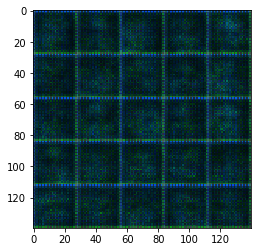

Epoch 1/1... Discriminator Loss: 0.4796... Generator Loss: 2.4058
Epoch 1/1... Discriminator Loss: 0.3851... Generator Loss: 3.3927
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.0659
Epoch 1/1... Discriminator Loss: 0.5972... Generator Loss: 1.9092
Epoch 1/1... Discriminator Loss: 0.4035... Generator Loss: 5.4277
Epoch 1/1... Discriminator Loss: 0.3740... Generator Loss: 4.0429
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 3.8102
Epoch 1/1... Discriminator Loss: 0.4052... Generator Loss: 3.0562
Epoch 1/1... Discriminator Loss: 0.4173... Generator Loss: 3.5286
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 4.0717


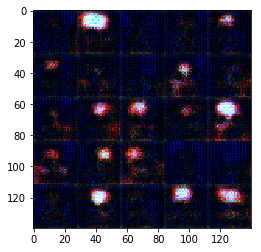

Epoch 1/1... Discriminator Loss: 0.4470... Generator Loss: 2.4963
Epoch 1/1... Discriminator Loss: 0.4560... Generator Loss: 2.6916
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 4.6804
Epoch 1/1... Discriminator Loss: 0.3906... Generator Loss: 3.4574
Epoch 1/1... Discriminator Loss: 0.4929... Generator Loss: 2.2004
Epoch 1/1... Discriminator Loss: 0.4374... Generator Loss: 2.8031
Epoch 1/1... Discriminator Loss: 0.6770... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 0.4600... Generator Loss: 2.6770
Epoch 1/1... Discriminator Loss: 0.4972... Generator Loss: 2.5564
Epoch 1/1... Discriminator Loss: 0.5641... Generator Loss: 3.1557


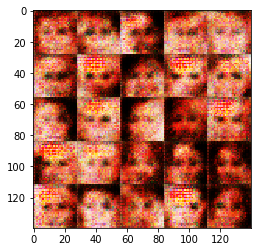

Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.2464
Epoch 1/1... Discriminator Loss: 1.6857... Generator Loss: 0.4948
Epoch 1/1... Discriminator Loss: 0.5216... Generator Loss: 2.4277
Epoch 1/1... Discriminator Loss: 0.5069... Generator Loss: 2.5626
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 0.9311... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.3863
Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 1.4522
Epoch 1/1... Discriminator Loss: 0.7412... Generator Loss: 2.6459
Epoch 1/1... Discriminator Loss: 0.6343... Generator Loss: 1.6598


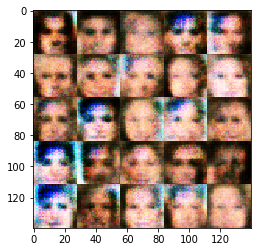

Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 2.2644
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.8875
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 0.6903... Generator Loss: 1.8995
Epoch 1/1... Discriminator Loss: 0.7071... Generator Loss: 3.1650
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.7035
Epoch 1/1... Discriminator Loss: 0.6759... Generator Loss: 1.5493
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 3.2209


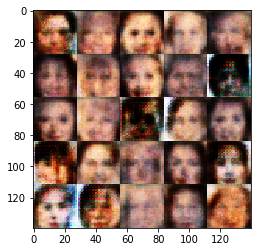

Epoch 1/1... Discriminator Loss: 0.6539... Generator Loss: 1.9623
Epoch 1/1... Discriminator Loss: 0.6741... Generator Loss: 1.7004
Epoch 1/1... Discriminator Loss: 0.7980... Generator Loss: 1.2565
Epoch 1/1... Discriminator Loss: 0.7740... Generator Loss: 1.3504
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 3.1527
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 2.0372
Epoch 1/1... Discriminator Loss: 0.6789... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.5922... Generator Loss: 3.8603
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.0302
Epoch 1/1... Discriminator Loss: 0.9120... Generator Loss: 2.1165


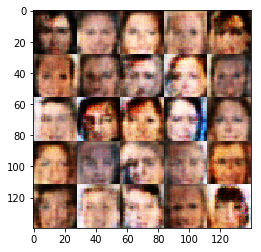

Epoch 1/1... Discriminator Loss: 0.4621... Generator Loss: 2.9564
Epoch 1/1... Discriminator Loss: 2.0875... Generator Loss: 0.2588
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 2.0897
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.5690
Epoch 1/1... Discriminator Loss: 1.0679... Generator Loss: 0.9760
Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 2.1123
Epoch 1/1... Discriminator Loss: 1.7234... Generator Loss: 2.3210
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 4.7606
Epoch 1/1... Discriminator Loss: 0.9845... Generator Loss: 0.8898


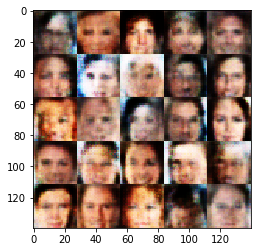

Epoch 1/1... Discriminator Loss: 0.6493... Generator Loss: 1.6988
Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 3.8634
Epoch 1/1... Discriminator Loss: 2.2041... Generator Loss: 0.2143
Epoch 1/1... Discriminator Loss: 0.6134... Generator Loss: 2.4370
Epoch 1/1... Discriminator Loss: 0.5932... Generator Loss: 2.6805
Epoch 1/1... Discriminator Loss: 0.4500... Generator Loss: 4.3174
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 2.5951
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 1.8472
Epoch 1/1... Discriminator Loss: 0.5208... Generator Loss: 3.9556


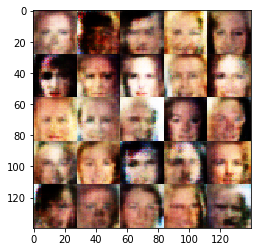

Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 4.5654
Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.9998
Epoch 1/1... Discriminator Loss: 1.2103... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 2.0774
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 2.7699
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 2.7129
Epoch 1/1... Discriminator Loss: 0.5490... Generator Loss: 1.9097
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.4465
Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.1417
Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 2.0369


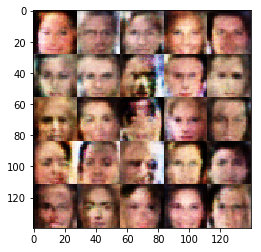

Epoch 1/1... Discriminator Loss: 1.0119... Generator Loss: 2.9691
Epoch 1/1... Discriminator Loss: 0.5401... Generator Loss: 2.2095
Epoch 1/1... Discriminator Loss: 0.5232... Generator Loss: 2.5490
Epoch 1/1... Discriminator Loss: 0.4257... Generator Loss: 3.1277
Epoch 1/1... Discriminator Loss: 0.6548... Generator Loss: 1.5990
Epoch 1/1... Discriminator Loss: 0.6769... Generator Loss: 1.7391
Epoch 1/1... Discriminator Loss: 0.5090... Generator Loss: 2.7046
Epoch 1/1... Discriminator Loss: 0.6483... Generator Loss: 1.6709
Epoch 1/1... Discriminator Loss: 2.5231... Generator Loss: 0.1523
Epoch 1/1... Discriminator Loss: 0.9878... Generator Loss: 1.1692


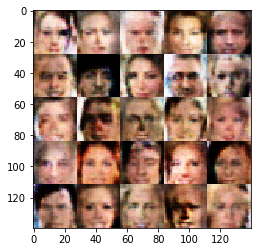

Epoch 1/1... Discriminator Loss: 1.0145... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 0.5825... Generator Loss: 3.0341
Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.6521
Epoch 1/1... Discriminator Loss: 0.8007... Generator Loss: 2.0868
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 1.6065


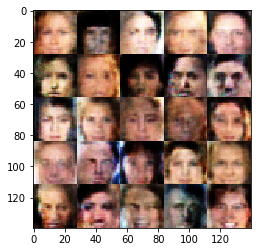

Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 0.5085... Generator Loss: 2.1809
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5325
Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 1.6021
Epoch 1/1... Discriminator Loss: 0.4077... Generator Loss: 3.3289
Epoch 1/1... Discriminator Loss: 0.4978... Generator Loss: 2.4625
Epoch 1/1... Discriminator Loss: 0.5063... Generator Loss: 2.0957
Epoch 1/1... Discriminator Loss: 0.7020... Generator Loss: 1.6872
Epoch 1/1... Discriminator Loss: 0.4160... Generator Loss: 2.9678


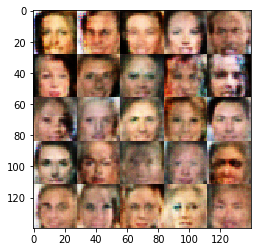

Epoch 1/1... Discriminator Loss: 2.0605... Generator Loss: 1.2719
Epoch 1/1... Discriminator Loss: 0.5587... Generator Loss: 1.9419
Epoch 1/1... Discriminator Loss: 0.3939... Generator Loss: 3.6690
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 0.8824
Epoch 1/1... Discriminator Loss: 0.6149... Generator Loss: 2.9287
Epoch 1/1... Discriminator Loss: 0.5909... Generator Loss: 1.6767
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.7857
Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.2089
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 0.7442... Generator Loss: 4.3785


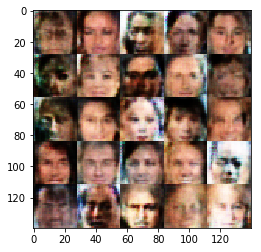

Epoch 1/1... Discriminator Loss: 0.7203... Generator Loss: 1.4368
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 0.5626... Generator Loss: 2.0306
Epoch 1/1... Discriminator Loss: 0.4611... Generator Loss: 4.1067
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 4.4494
Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 2.5069
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.4504
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.4667... Generator Loss: 2.3895


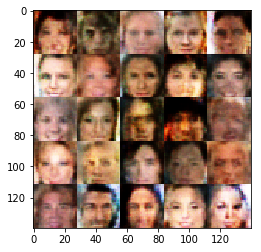

Epoch 1/1... Discriminator Loss: 0.6120... Generator Loss: 1.7555
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 1.5666
Epoch 1/1... Discriminator Loss: 0.7467... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9126
Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.0838
Epoch 1/1... Discriminator Loss: 0.7430... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 0.8581... Generator Loss: 1.2853


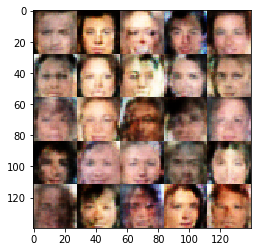

Epoch 1/1... Discriminator Loss: 0.5298... Generator Loss: 3.3575
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.3895
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 1.0632
Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.6732
Epoch 1/1... Discriminator Loss: 0.7652... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 0.6185... Generator Loss: 4.6008
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 2.1207
Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 1.5379
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 3.0855


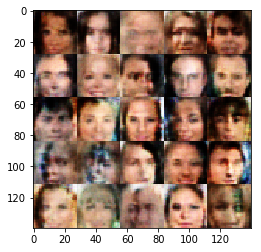

Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 1.5678
Epoch 1/1... Discriminator Loss: 0.4144... Generator Loss: 3.1420
Epoch 1/1... Discriminator Loss: 0.5037... Generator Loss: 2.1325
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 1.9401
Epoch 1/1... Discriminator Loss: 0.5576... Generator Loss: 4.1718
Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 0.7811... Generator Loss: 1.5138
Epoch 1/1... Discriminator Loss: 0.4798... Generator Loss: 2.1902
Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 2.7299
Epoch 1/1... Discriminator Loss: 0.9728... Generator Loss: 0.9738


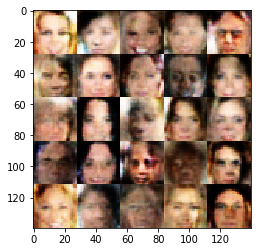

Epoch 1/1... Discriminator Loss: 0.4568... Generator Loss: 5.6322
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.5785
Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.1931
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 0.8364
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.2387
Epoch 1/1... Discriminator Loss: 0.4722... Generator Loss: 2.4440
Epoch 1/1... Discriminator Loss: 0.6708... Generator Loss: 2.0408
Epoch 1/1... Discriminator Loss: 0.8219... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 4.4113


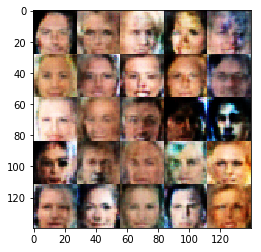

Epoch 1/1... Discriminator Loss: 0.6359... Generator Loss: 1.5184
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 2.9350
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 4.4444
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.8105
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 2.0282
Epoch 1/1... Discriminator Loss: 0.4861... Generator Loss: 2.4198
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 1.8704
Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 2.1267
Epoch 1/1... Discriminator Loss: 0.4882... Generator Loss: 2.1646


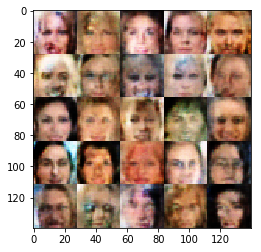

Epoch 1/1... Discriminator Loss: 0.3912... Generator Loss: 3.4497
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.1923
Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.3603
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 0.4580... Generator Loss: 3.0654
Epoch 1/1... Discriminator Loss: 0.4207... Generator Loss: 2.8116
Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.5540


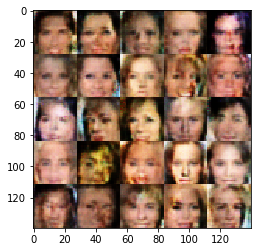

Epoch 1/1... Discriminator Loss: 0.4229... Generator Loss: 5.2457
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.2663
Epoch 1/1... Discriminator Loss: 1.0412... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.4484
Epoch 1/1... Discriminator Loss: 0.7018... Generator Loss: 1.9158
Epoch 1/1... Discriminator Loss: 1.0239... Generator Loss: 1.0225
Epoch 1/1... Discriminator Loss: 1.4451... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 0.8487... Generator Loss: 1.3629
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.2441
Epoch 1/1... Discriminator Loss: 0.6740... Generator Loss: 1.5591


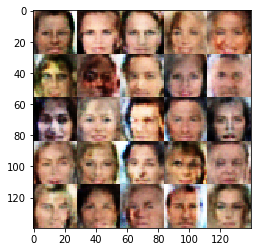

Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 2.3305
Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 0.5022... Generator Loss: 2.1786
Epoch 1/1... Discriminator Loss: 1.1423... Generator Loss: 0.9003
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 1.2454
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 3.6450
Epoch 1/1... Discriminator Loss: 0.4957... Generator Loss: 2.7012
Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 2.3687
Epoch 1/1... Discriminator Loss: 0.5656... Generator Loss: 1.7306
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.5972


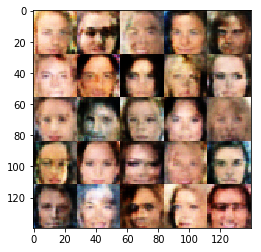

Epoch 1/1... Discriminator Loss: 0.4884... Generator Loss: 2.8662
Epoch 1/1... Discriminator Loss: 0.4098... Generator Loss: 3.2047
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 2.9383
Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.2785
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 1.7350
Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 2.4610
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 1.0840
Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 1.1978


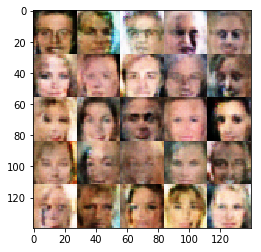

Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0288
Epoch 1/1... Discriminator Loss: 0.7708... Generator Loss: 1.4294
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 0.6157... Generator Loss: 1.9904
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 1.5861
Epoch 1/1... Discriminator Loss: 0.6319... Generator Loss: 1.8022
Epoch 1/1... Discriminator Loss: 1.1344... Generator Loss: 0.9720
Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 1.1277


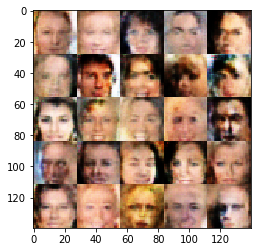

Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.0547
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.5917
Epoch 1/1... Discriminator Loss: 0.9953... Generator Loss: 1.0321
Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.1383
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.1066
Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.8518
Epoch 1/1... Discriminator Loss: 1.2463... Generator Loss: 1.8977
Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.0720
Epoch 1/1... Discriminator Loss: 0.8560... Generator Loss: 1.6058


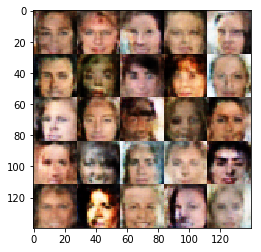

Epoch 1/1... Discriminator Loss: 1.1000... Generator Loss: 1.2200
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 0.8426... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 0.7773... Generator Loss: 1.4945
Epoch 1/1... Discriminator Loss: 0.5295... Generator Loss: 2.3913
Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 0.9553
Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 1.0520
Epoch 1/1... Discriminator Loss: 0.8895... Generator Loss: 1.4081


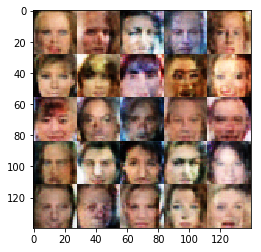

Epoch 1/1... Discriminator Loss: 0.8046... Generator Loss: 1.5131
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.9536
Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 0.8362... Generator Loss: 3.0092
Epoch 1/1... Discriminator Loss: 0.4367... Generator Loss: 3.2691
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 3.3485
Epoch 1/1... Discriminator Loss: 0.6048... Generator Loss: 1.8340
Epoch 1/1... Discriminator Loss: 0.3623... Generator Loss: 5.4593
Epoch 1/1... Discriminator Loss: 1.0988... Generator Loss: 0.7069


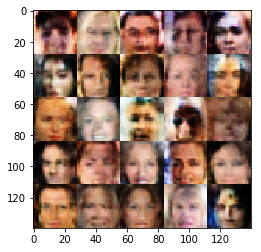

Epoch 1/1... Discriminator Loss: 0.6629... Generator Loss: 1.4032
Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 2.5955
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.4791
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.2071
Epoch 1/1... Discriminator Loss: 0.6284... Generator Loss: 1.6189
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.3847
Epoch 1/1... Discriminator Loss: 0.5156... Generator Loss: 2.0790
Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.2648
Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 2.8222
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 4.1116


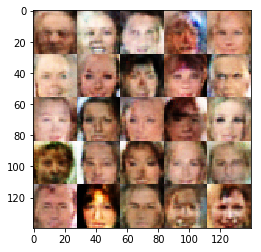

Epoch 1/1... Discriminator Loss: 0.5694... Generator Loss: 1.7609
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 3.2643
Epoch 1/1... Discriminator Loss: 1.9942... Generator Loss: 0.3000
Epoch 1/1... Discriminator Loss: 0.6543... Generator Loss: 1.5500
Epoch 1/1... Discriminator Loss: 0.3883... Generator Loss: 3.5143
Epoch 1/1... Discriminator Loss: 0.4217... Generator Loss: 2.8843
Epoch 1/1... Discriminator Loss: 0.4809... Generator Loss: 2.2613
Epoch 1/1... Discriminator Loss: 0.8434... Generator Loss: 2.9440
Epoch 1/1... Discriminator Loss: 0.7211... Generator Loss: 1.5723
Epoch 1/1... Discriminator Loss: 0.9076... Generator Loss: 0.9476


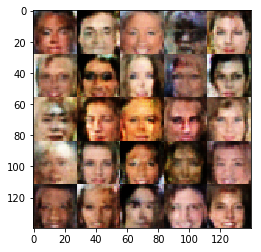

Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 4.1305
Epoch 1/1... Discriminator Loss: 0.4666... Generator Loss: 3.5532
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 0.4499... Generator Loss: 2.8110
Epoch 1/1... Discriminator Loss: 0.5682... Generator Loss: 2.2969
Epoch 1/1... Discriminator Loss: 0.6820... Generator Loss: 2.0960
Epoch 1/1... Discriminator Loss: 0.6168... Generator Loss: 1.6353
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 1.6781
Epoch 1/1... Discriminator Loss: 0.8111... Generator Loss: 1.1794
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 3.2549


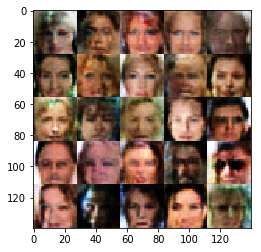

Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 0.9635
Epoch 1/1... Discriminator Loss: 0.4002... Generator Loss: 3.4042
Epoch 1/1... Discriminator Loss: 0.5925... Generator Loss: 1.6170
Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 3.6971
Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.3175
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.7718
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.7849
Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.3997
Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.8911
Epoch 1/1... Discriminator Loss: 0.3806... Generator Loss: 3.8047


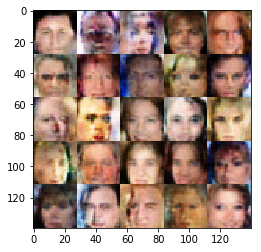

Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 0.8784... Generator Loss: 1.5991
Epoch 1/1... Discriminator Loss: 0.9488... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 1.9740
Epoch 1/1... Discriminator Loss: 0.6209... Generator Loss: 1.5792
Epoch 1/1... Discriminator Loss: 0.8842... Generator Loss: 1.4045


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)